# Capstone Project Source Code

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt

# Pretty display for notebooks      
%matplotlib inline

## Data cleaning
Remove "click only" entries & entries with NA values

In [37]:
# Drop entries with NA values and is_booking==0 then sample 100k data

train = pd.read_csv("data/train.csv")
train_reduced = train.dropna()
train_reduced = train_reduced[train_reduced.is_booking==1]
train_reduced = train_reduced.sample(n=100000,random_state=1)
destination = pd.read_csv("data/destinations.csv")

In [2]:
# Load data

train_reduced = pd.read_csv("data/train_reduced_sampled_pp.csv")
#train_reduced = pd.read_csv("data/train_reduced_exploration.csv")
train_reduced = train_reduced.drop(columns=['Unnamed: 0'])

## Data Exploration & Exploratory Visualization

### Summary Statistics

In [7]:
n_records = len(train_reduced)
print("Total number of records in reduced dataset: {}".format(n_records))
display(train_reduced.head(1))
display(destination.head(1))

Total number of records in reduced dataset: 100000


,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,duration
0,2,3,66,220,5420,533.1818,827562,0,0,9,2,0,1,5,1,2,50,748,40,2


,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657


### Create duration feature

In [10]:
# Convert string column to type datetime 64[ns] 
train_reduced['srch_ci'] = train_reduced['srch_ci'].astype('datetime64[ns]')
train_reduced['srch_co'] = train_reduced['srch_co'].astype('datetime64[ns]')

In [31]:
# get number of days between checkout and checkin dates
train_reduced['duration'] = (train_reduced['srch_co']-train_reduced['srch_ci']).dt.days
# remove entries where checkout date < checkin date
train_reduced = train_reduced[train_reduced['duration']>0]

### Hotel cluster distribution

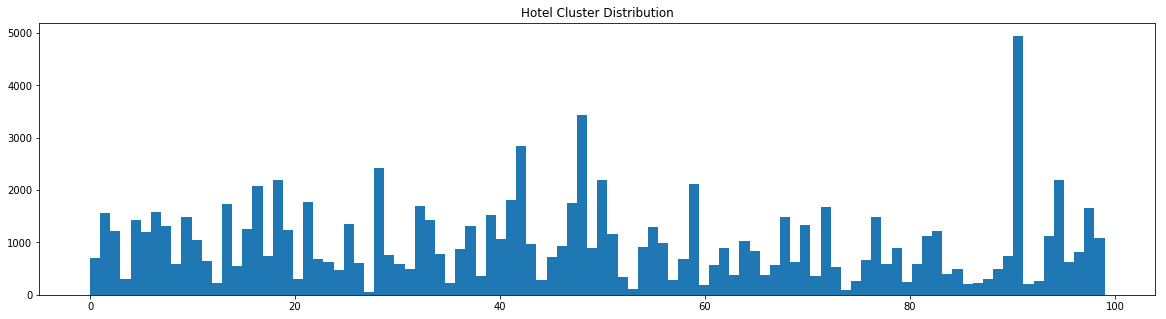

The most booked hotel cluster is: 91


In [9]:
plt.figure(figsize=(20,5))
plt.hist(train_reduced['hotel_cluster'],100,histtype='bar')
plt.title('Hotel Cluster Distribution')
plt.show()

most_booked_hotel_cluster = train_reduced['hotel_cluster'].value_counts().idxmax()
print("The most booked hotel cluster is: {}".format(most_booked_hotel_cluster))

### Features distribution (TO DO! read in train_reduced_preprocessed)

identify sparese categorical variables & skewed numerical variables

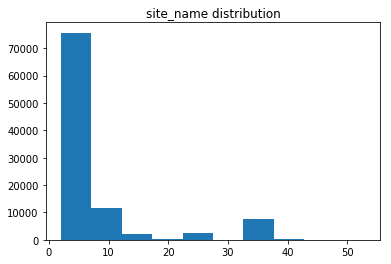

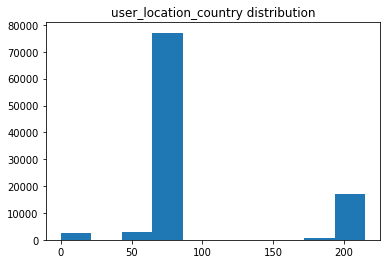

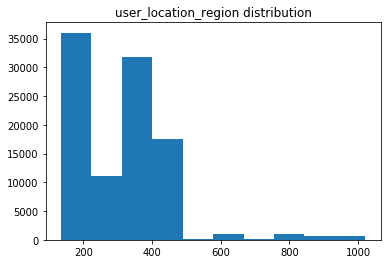

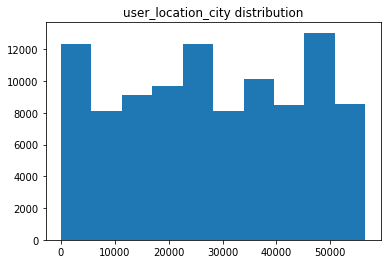

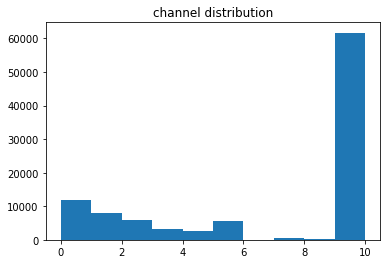

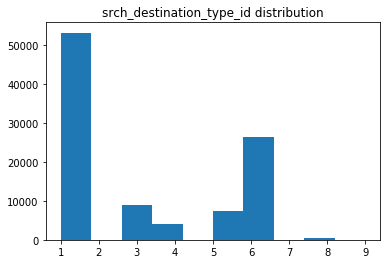

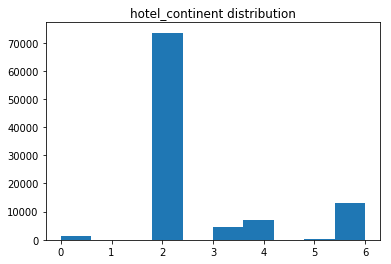

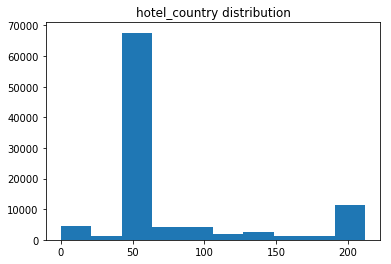

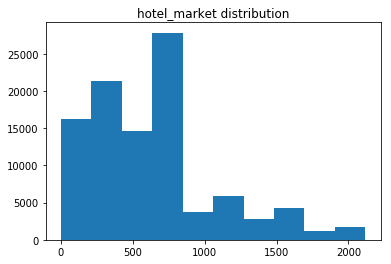

In [19]:
categorical_cols = ['site_name','user_location_country','user_location_region','user_location_city',
                'channel','srch_destination_type_id','hotel_continent','hotel_country','hotel_market']

for i in categorical_cols:  
    plt.hist(train_reduced[i],histtype='bar')
    plt.title(i+' distribution')
    plt.show()

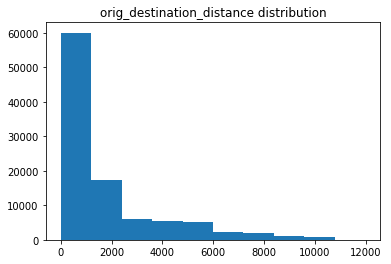

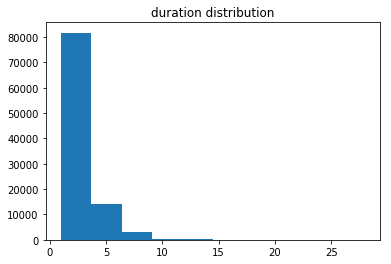

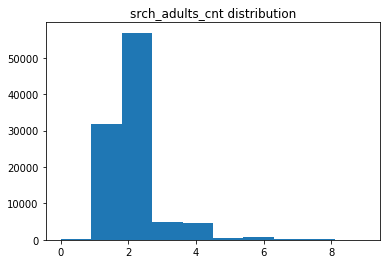

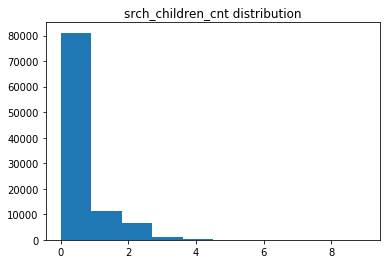

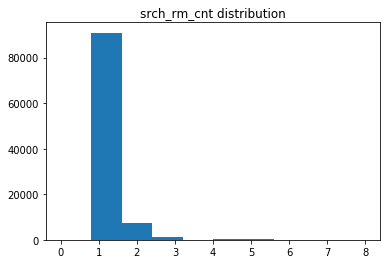

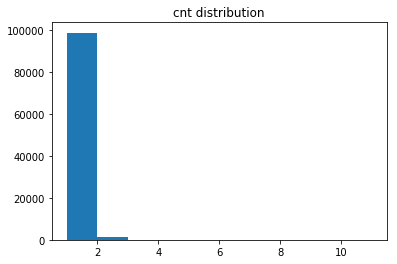

In [20]:
numeric_cols = ['orig_destination_distance','duration','srch_adults_cnt','srch_children_cnt',
                   'srch_rm_cnt','cnt']
for i in numeric_cols:  
    plt.hist(train_reduced[i],histtype='bar')
    plt.title(i+' distribution')
    plt.show()

### Correlation Matrix (explain observations in report !)

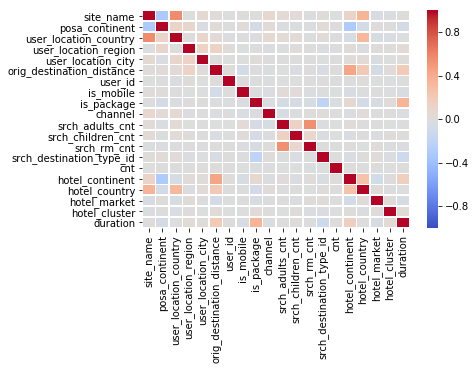

In [36]:
import seaborn as sns
sns.heatmap(train_reduced.corr(),center=0,vmin=-1,vmax=1,linewidths=.5,cmap='coolwarm')

## Data Pre-processing
minmax scalar for numerical variable for skewed 

one-hot encoding for categorical variable

left join destination table in (key srch_destination_id)

In [6]:
# find rare values (less than 5% of data) and encode as -999

categorical_cols = ['site_name','user_location_country','user_location_region','user_location_city',
                'channel','srch_destination_type_id','hotel_continent','hotel_country','hotel_market']

for i in categorical_cols:
    distinct_cnt = len(train_reduced[i].unique())
    col_freq_cnt = train_reduced[i].value_counts()
    col_cum_freq = col_freq_cnt.cumsum()/col_freq_cnt.sum()
    idx = list(col_cum_freq[(col_cum_freq<0.95)].index)
    train_reduced.loc[~train_reduced[i].isin(idx), i]=-999

In [7]:
# execute binary encoding

import category_encoders as ce
categorical_cols.append('posa_continent')
encoder = ce.BinaryEncoder(cols=categorical_cols)
train_reduced = encoder.fit_transform(train_reduced)

In [8]:
# Log-transform the skewed features

numeric_skewed = ['orig_destination_distance','duration','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','cnt']
train_reduced[numeric_skewed] = train_reduced[numeric_skewed].apply(lambda x: np.log(x + 1))

In [9]:
# apply minmax scalar

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_reduced[numeric_skewed] = scaler.fit_transform(train_reduced[numeric_skewed])

In [12]:
# PCA on destination dataset - reduced from 150 to 10 features

from sklearn.decomposition import PCA
d = destination.drop(columns=['srch_destination_id'])
pca = PCA(n_components=10).fit(d)
destination_reduced = pca.transform(d)
destination_reduced = pd.DataFrame(destination_reduced, columns = ['Dim 1','Dim 2','Dim 3','Dim 4','Dim 5','Dim 6','Dim 7','Dim 8','Dim 9','Dim 10'])
destination_reduced = pd.concat([pd.DataFrame(destination['srch_destination_id']),destination_reduced],axis=1)

In [13]:
# left join back to training data
train_reduced = pd.merge(left=train_reduced,right=destination_reduced,how='left')
# drop rows with NA values (not in destination.csv)
train_reduced = train_reduced.dropna()
train_reduced = train_reduced.drop(columns = ['date_time','user_id',
                               'srch_ci','srch_co','srch_destination_id','is_booking'])

## Train Models

In [31]:
# split into training and testing set

from sklearn.model_selection import train_test_split
hotel_cluster = train_reduced['hotel_cluster']
features = train_reduced.drop(columns = ['hotel_cluster'])

X_train, X_test, y_train, y_test = train_test_split(features, hotel_cluster, 
                                                    test_size=0.1, random_state=1)

# split into training and validation set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.1, random_state=1)

from sklearn.externals import joblib

### Baseline / Benchmark Model

In [4]:
# predict each row as top 5 most common cluster in training data

top5most_common_clusters = list(train_reduced['hotel_cluster'].value_counts()[0:5].index)
pred_baseline = [top5most_common_clusters for i in range(len(y_test))]
pred_baseline[0]

[91, 48, 42, 28, 95]

In [35]:
# function to return top 5 hotel cluster base on probablity vector input
def find_top5_cluster(pred_prob):
    pred=[]
    for i in range(len(pred_prob)):
        pred.append(list(pred_prob[i].argsort()[::-1][:5]))
    return pred

### XGBoost Model

In [8]:
# fit XGBoost classifier

from xgboost import XGBClassifier
mod_xgb = XGBClassifier()
mod_xgb.fit(X_train, y_train)

joblib.dump(mod_xgb, 'XGBoost.pkl')

['XGBoost.pkl']

In [19]:
# Load trained models
mod_xgb = joblib.load('XGBoost.pkl')

# get prediction probablity of each hotel cluster in X_test
pred_prob = mod_xgb.predict_proba(X_val)
# get top 5 most probable cluster per prediction and make result into list of list
pred_xgb = find_top5_cluster(pred_prob)

### KNN Model

In [12]:
# fit KNN classifier

from sklearn.neighbors import KNeighborsClassifier
mod_knn = KNeighborsClassifier()
mod_knn.fit(X_train, y_train)

# save trained model down as pkl file
joblib.dump(mod_knn, 'knn.pkl')

['knn.pkl']

In [20]:
# Load trained models
mod_knn = joblib.load('knn.pkl')

# get prediction probablity of each hotel cluster in X_test
pred_prob = mod_knn.predict_proba(X_val)
# get top 5 most probable cluster per prediction and make result into list of list
pred_knn = find_top5_cluster(pred_prob)

### LightGBM Model

In [16]:
import lightgbm as lgb
train = lgb.Dataset(X_train,label=y_train)
param = {'objective':'multiclass','num_class':100}
mod_lgbm = lgb.train(param,train_set=train)
# save trained model down as pkl file
joblib.dump(mod_lgbm, 'lgbm.pkl')

['lgbm.pkl']

In [7]:
# Load trained models
mod_lgbm = joblib.load('lgbm.pkl')
    
pred_prob = mod_lgbm.predict(X_val)
pred_lgbm = find_top5_cluster(pred_prob)

### Evaluation based on validation set

In [22]:
# implement MAP@5 as evaluation metric

import ml_metrics as metrics

target_v = [[l] for l in y_val]

print("The MAP@5 score for Baseline model is {}".format(metrics.mapk(target_v, pred_baseline, k=5)))
print("The MAP@5 score for XGBoost model is {}".format(metrics.mapk(target_v, pred_xgb, k=5)))
print("The MAP@5 score for KNN model is {}".format(metrics.mapk(target_v, pred_knn, k=5)))
print("The MAP@5 score for LightGBM model is {}".format(metrics.mapk(target_v, pred_lgbm, k=5)))

The MAP@5 score for Baseline model is 0.08724932098076423
The MAP@5 score for XGBoost model is 0.24781597648547085
The MAP@5 score for KNN model is 0.1464914238940358
The MAP@5 score for LightGBM model is 0.2645849611191725


### Evaludation based on test set (unseen data) for best model

In [118]:
# Load trained models
mod_lgbm = joblib.load('lgbm.pkl')

# get prediction probablity of each hotel cluster in X_test
pred_prob = mod_lgbm.predict(X_test)
# get top 5 most probable cluster per prediction and make result into list of list
pred_lgbm_test = find_top5_cluster(pred_prob)

target_t = [[l] for l in y_test]
metrics.mapk(target_t, pred_lgbm_test, k=5)

0.2732395781014566

### LightGBM robustness test

In [43]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import ml_metrics as metrics

hotel_cluster = train_reduced['hotel_cluster']
features = train_reduced.drop(columns = ['hotel_cluster'])

def trainlgbm(rand_state_n):
    
    # split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(features, hotel_cluster, 
                                                        test_size=0.1, random_state=rand_state_n)
    # split into training and validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=0.1, random_state=rand_state_n)
    
    target_v = [[l] for l in y_val]
    target_t = [[l] for l in y_test]
    
    train = lgb.Dataset(X_train,label=y_train)
    param = {'objective':'multiclass','num_class':100}
    mod_lgbm = lgb.train(param,train_set=train)
    pred_prob = mod_lgbm.predict(X_val)
    pred_lgbm = find_top5_cluster(pred_prob)
    mapk_v=metrics.mapk(target_v,pred_lgbm, k=5)
    
    pred_prob = mod_lgbm.predict(X_test)
    pred_lgbm = find_top5_cluster(pred_prob)
    mapk_t=metrics.mapk(target_t, pred_lgbm, k=5)
    
    return (mapk_v,mapk_t)

In [55]:
# intialize random states 2 to 10
rand_states = [2,3,4,5,6,7,8,9,10]
mapk_v = []
mapk_t = []

# get map@5 scores for validation and test sets for each random state
for i in rand_states:
    l = trainlgbm(i)
    mapk_v.append(l[0])
    mapk_t.append(l[1])

In [59]:
np.var(mapk_t)

7.439635698291375e-06

### Refinement for LightGBM

In [61]:
import lightgbm as lgb
from sklearn.grid_search import GridSearchCV

parameters = {'learning_rate': [0.05,0.1,0.2],'num_leaves': [21,31,51]}
model = lgb.LGBMClassifier(objective = 'multiclass',num_class = 100)

grid_obj = GridSearchCV(model,parameters)
grid_fit = grid_obj.fit(X_train, y_train.values.ravel())
best_mod_lgbm = grid_fit.best_estimator_
joblib.dump(best_mod_lgbm, 'best_lgbm.pkl')
grid_fit.best_params_

C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if dif

KeyboardInterrupt: 

In [ ]:
# Load best model
best_mod_lgbm = joblib.load('best_lgbm.pkl')

# get prediction probablity of each hotel cluster in X_test
pred_prob = best_mod_lgbm.predict_proba(X_test)
# get top 5 most probable cluster per prediction and make result into list of list
pred_best_lgbm_test = find_top5_cluster(pred_prob)

target_t = [[l] for l in y_test]
metrics.mapk(target_t, pred_best_lgbm_test, k=5)

### Refinement for XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV

parameters = {'max_depth': [3,6,9],'learning_rate': [0.05,0.2,0.3]}
model = XGBClassifier()

grid_obj = GridSearchCV(model,parameters)
grid_fit = grid_obj.fit(X_train, y_train.values.ravel())
best_mod_xgb = grid_fit.best_estimator_
joblib.dump(best_mod_xgb, 'best_xgb.pkl')
grid_fit.best_params_

C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

In [ ]:
# Load best model
best_mod_xgb = joblib.load('best_xgb.pkl')

# get prediction probablity of each hotel cluster in X_test
pred_prob = best_mod_xgb.predict_proba(X_test)
# get top 5 most probable cluster per prediction and make result into list of list
pred_best_xgb_test = find_top5_cluster(pred_prob)

target_t = [[l] for l in y_test]
metrics.mapk(target_t, pred_best_xgb_test, k=5)

### Refinement for KNN

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

parameters = {'n_neighbors': [3, 5, 10, 15]}
model = KNeighborsClassifier()

grid_obj = GridSearchCV(model,parameters)
grid_fit = grid_obj.fit(X_train, y_train.values.ravel())
best_mod_knn = grid_fit.best_estimator_
joblib.dump(best_mod_knn, 'best_knn.pkl')
grid_fit.best_params_

C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ahtha\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'n_neighbors': 15}

In [58]:
# Load best model
best_mod_knn = joblib.load('best_knn.pkl')

# get prediction probablity of each hotel cluster in X_test
pred_prob = best_mod_knn.predict_proba(X_test)
# get top 5 most probable cluster per prediction and make result into list of list
pred_best_knn_test = find_top5_cluster(pred_prob)

target_t = [[l] for l in y_test]
metrics.mapk(target_t, pred_best_knn_test, k=5)

0.1683776996484179

### Feature Importance (Free Form Visualization)

In [110]:
def feature_plot(importances, X_train, y_train):
    
    # Display the ten most important features
    importances = importances.astype(float)
    importances *= 1/importances.sum()
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (9,7))
    plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns)
    plt.xlim((-0.5, 10))
    #plt.yticks(np.arange(0, 0.5, 0.01))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    plt.xticks(rotation=50)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

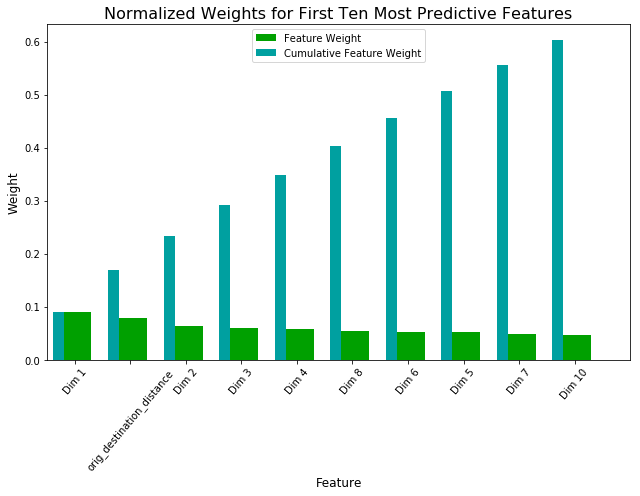

In [111]:
importances = best_mod_lgbm.feature_importances_
feature_plot(importances, X_train, y_train)